In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
%load_ext watermark
%watermark -u -n -t -z -v -p numpy,scipy,neupy,scikit-learn,matplotlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
last updated: Thu Jan 24 2019 11:13:23 CET

CPython 3.5.6
IPython 7.1.1

numpy 1.14.5
scipy 1.2.0
neupy 0.8.0
sklearn 0.20.2
matplotlib 3.0.1


/Users/itdxer/.pyenv/versions/3.5.6/envs/py35/lib/python3.5/site-packages/watermark/watermark.py:155: DeprecationWarning: Importing scikit-learn as `scikit-learn` has been depracated and will not be supported anymore in v1.7.0. Please use the package name `sklearn` instead.
  DeprecationWarning)


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

## VGG19

In [7]:
from neupy import architectures
vgg19 = architectures.vgg19()
vgg19

(?, 224, 224, 3) -> [... 47 layers ...] -> (?, 1000)

## Download VGG19 pre-trained weights

In [8]:
import os
import sys

CURRENT_DIR = os.path.abspath(os.path.dirname(__name__))
CNN_EXAMPLE_FILES = os.path.join(CURRENT_DIR, '..', 'examples', 'cnn')
VGG19_WEIGHTS_FILE = os.path.join(CNN_EXAMPLE_FILES, 'files', 'vgg19.hdf5')

sys.path.append(CNN_EXAMPLE_FILES)

In [9]:
# requires also modules: requests and tqdm
from imagenet_tools import download_file, load_image, deprocess

In [10]:
import os
from neupy import storage

if not os.path.exists(VGG19_WEIGHTS_FILE):
    download_file(
        url="http://neupy.s3.amazonaws.com/tensorflow/imagenet-models/vgg19.hdf5",
        filepath=VGG19_WEIGHTS_FILE,
        description='Downloading weights')

storage.load(vgg19, VGG19_WEIGHTS_FILE)

## Visualize learned features by different filters in different layers

conv5_4 layer: 100%|██████████| 5/5 [01:35<00:00, 19.13s/it]


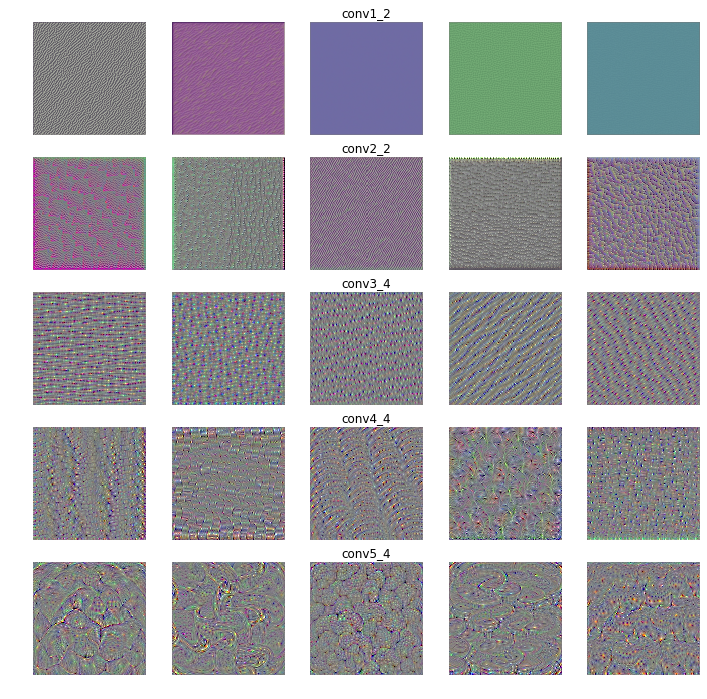

In [11]:
from itertools import product
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from neupy.utils import tensorflow_session

def normalize(input_img_data):
    x = input_img_data[0]
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

layer_names = ('conv1_2', 'conv2_2', 'conv3_4', 'conv4_4', 'conv5_4')
fig, axes = plt.subplots(len(layer_names), 5, figsize=(12, 12))
sess = tensorflow_session()

for i, output_layer_name in enumerate(layer_names):
    desc = "{} layer".format(output_layer_name)
    
    x = tf.placeholder(tf.float32)
    res = vgg19.end(output_layer_name).output(x)
        
    row_axes = axes[i]
    
    for j in tqdm(list(range(5)), desc=desc):
        loss = tf.reduce_mean(res[:, :, :, j])
        grad, = tf.gradients(loss, x)
        grad /= (tf.sqrt(tf.reduce_mean(tf.square(grad))) + 1e-7)

        # we start from a gray image with some noise
        input_img_data = (np.random.random((1, 224, 224, 3)) * 20 + 128).astype(np.float32)

        step = 100.
        for _ in range(20):
            loss_value, grads_value = sess.run([loss, grad], feed_dict={x: input_img_data})
            input_img_data = input_img_data + grads_value * step

        input_img_data = normalize(input_img_data)
        
        row_axes[j].imshow(input_img_data[:, :, ::-1])
        row_axes[j].axis('off')
        
    row_axes[2].set_title(output_layer_name)

## Saliency map

In [17]:
dog = load_image('images/dog.jpg', image_size=(256, 256), crop_size=(224, 224))

/Users/projects/trash/neupy/notebooks/../examples/cnn/imagenet_tools.py:37: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  image = imread(image_name, mode='RGB')
/Users/itdxer/.pyenv/versions/3.5.6/envs/py35/lib/python3.5/site-packages/scipy/misc/pilutil.py:165: DeprecationWarning: `fromimage` is deprecated!
`fromimage` is deprecated in SciPy 1.0.0. and will be removed in 1.2.0.
Use ``np.asarray(im)`` instead.
  return fromimage(im, flatten=flatten, mode=mode)


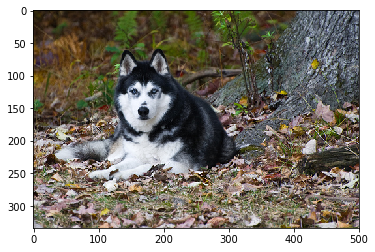

In [18]:
from imageio import imread
plt.imshow(imread('images/dog.jpg'));

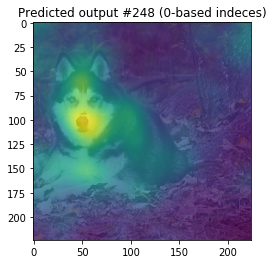

In [19]:
from neupy import plots
plt.imshow(deprocess(dog[0]))
plots.saliency_map(vgg19, dog, alpha=0.8, sigma=10);

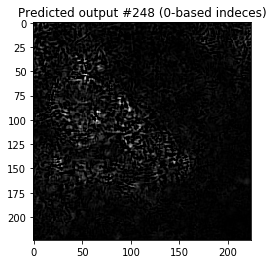

In [20]:
plots.saliency_map(vgg19, dog[0], mode='raw', vmin=0);